CHATBOT WITH TOOLS AND MEMORY - Bit Like an Agent

In [1]:
from dotenv import load_dotenv
load_dotenv('.env')	
import os

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START,END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

In [3]:
# from langchain.llms import OpenAI

# llm = {
#     "config_list": [{"model": "gemini-1.5-flash", "api_key": os.environ["GEMINI_API_KEY"]}],
# }

In [4]:
# pip install -U langchain-google-genai

In [5]:
base_url = "http://localhost:11434/"


llm= ChatOllama(
    base_url=base_url,
    model='llama3.2',
    temperature=0.9
)


In [6]:
# from langchain_google_genai import ChatGoogleGenerativeAI

# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=os.environ["GEMINI_API_KEY"])
# llm.invoke("Sing a ballad of LangChain.")

In [7]:
@tool
def webSearch(prompt: str) -> str:
    """
    Search the web for the realtime and latest information on the given prompt.
    for example, news, articles, blogs, stock market, etc.

    Args:
        prompt: The prompt to search for.
    """
    search = TavilySearchResults(
        max_results=3,
        search_depth='advanced',
        include_answer=True,
        include_raw_content=True,
    )
    response = search.invoke(prompt)
    
    return response

# print(webSearch('Who is the current president of the United States?'))
# search.invoke('Who is the president of the United States?')

In [8]:
@tool
def llmSearch(prompt: str) -> str:
    """
    Use the LLM model for general queries and basic information.
    """
    # message = HumanMessage(prompt)
    response = llm.invoke(prompt)
    return response

In [9]:
webSearch

StructuredTool(name='webSearch', description='Search the web for the realtime and latest information on the given prompt.\nfor example, news, articles, blogs, stock market, etc.\n\nArgs:\n    prompt: The prompt to search for.', args_schema=<class 'langchain_core.utils.pydantic.webSearch'>, func=<function webSearch at 0x0000029A0F4C7BA0>)

In [10]:
llmSearch

StructuredTool(name='llmSearch', description='Use the LLM model for general queries and basic information.', args_schema=<class 'langchain_core.utils.pydantic.llmSearch'>, func=<function llmSearch at 0x0000029A11D87EC0>)

In [11]:
tools = [webSearch, llmSearch]
tools

[StructuredTool(name='webSearch', description='Search the web for the realtime and latest information on the given prompt.\nfor example, news, articles, blogs, stock market, etc.\n\nArgs:\n    prompt: The prompt to search for.', args_schema=<class 'langchain_core.utils.pydantic.webSearch'>, func=<function webSearch at 0x0000029A0F4C7BA0>),
 StructuredTool(name='llmSearch', description='Use the LLM model for general queries and basic information.', args_schema=<class 'langchain_core.utils.pydantic.llmSearch'>, func=<function llmSearch at 0x0000029A11D87EC0>)]

In [12]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatOllama(model='llama3.2', temperature=0.9, base_url='http://localhost:11434/'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'webSearch', 'description': 'Search the web for the realtime and latest information on the given prompt.\nfor example, news, articles, blogs, stock market, etc.\n\nArgs:\n    prompt: The prompt to search for.', 'parameters': {'properties': {'prompt': {'type': 'string'}}, 'required': ['prompt'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'llmSearch', 'description': 'Use the LLM model for general queries and basic information.', 'parameters': {'properties': {'prompt': {'type': 'string'}}, 'required': ['prompt'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [13]:
class State(TypedDict):
    # {"messages" : []"your messagea"]}
    messages: Annotated[list, add_messages]

def chatBot(state: State) -> State:
    # message = state['message']
    response = llm_with_tools.invoke(state['messages'])
    return {'messages': [response]}

In [14]:
# graph = StateGraph(State)
def get_runnable():
    memory = MemorySaver()
    # memory = AsyncSqliteSaver.from_conn_string(":memory:")
    graph_builder = StateGraph(State)
    graph_builder.add_node('chatBot', chatBot)
    tool_node = ToolNode(tools=tools)

    graph_builder.add_node('tools', tool_node)
    graph_builder.add_conditional_edges('chatBot', tools_condition)

    graph_builder.add_edge("tools", 'chatBot')
    graph_builder.set_entry_point('chatBot')

    graph = graph_builder.compile(checkpointer=memory)
    return graph


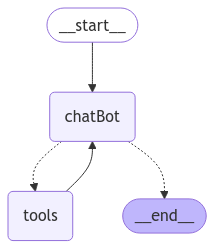

In [15]:
graph = get_runnable()
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
# graph.invoke({'messages': ['Let me know which political party won the latest Delhi CM elections in the year Feb-2025']})
config = {"configurable": {"thread_id": 1}}
while True:
    user_input = input("You: ")
    if user_input in ['exit', "quit", "q"]:
        print("Goodbye!")
        break
    output = graph.invoke({'messages': [user_input]}, config=config)
    output['messages'][-1].pretty_print()


================================== Ai Message ==================================

The latest winner of the Delhi CM elections in February 2025 is from the Bharatiya Janata Party (BJP). According to the election results, the BJP has won 47 out of the 70 assembly seats, while the Aam Aadmi Party (AAP) has won 23 seats. The BJP will form a government in Delhi after more than 26 years.
Goodbye!


In [88]:
# async def prompt_ai(messages):
#     config = {
#         "configurable": {
#             "thread_id": 1
#         }
#     }

#     async for event in graph.astream_events(
#             {"messages": messages}, config, version="v2"
#         ):
#             if event["event"] == "on_chat_model_stream":
#                 yield event["data"]["chunk"].content

In [ ]:
# config = {"configurable": {"thread_id": 1}}
# while True:
#     user_input = input("You: ")
#     if user_input in ['exit', "quit", "q"]:
#         print("Goodbye!")
#         break
#     response_content=''
#     async for chunk in prompt_ai(user_input):
#                 response_content += chunk
#                 print(response_content)
#     # output = graph.invoke({'messages': [user_input]}, config=config)
#     # output['messages'][-1].pretty_print()
#     # print("Bot:", response_content)

The
The biting wind whipped at James Bond’s tailored suit as he stood atop the Matter
The biting wind whipped at James Bond’s tailored suit as he stood atop the Matterhorn, the icy peaks of the Swiss Alps a stark backdrop to the clandestine meeting
The biting wind whipped at James Bond’s tailored suit as he stood atop the Matterhorn, the icy peaks of the Swiss Alps a stark backdrop to the clandestine meeting unfolding below.  His target:  Ernst Stavro Blofeld, the enigmatic leader of SPECTRE, was holding a summit with a group of shadowy figures –
The biting wind whipped at James Bond’s tailored suit as he stood atop the Matterhorn, the icy peaks of the Swiss Alps a stark backdrop to the clandestine meeting unfolding below.  His target:  Ernst Stavro Blofeld, the enigmatic leader of SPECTRE, was holding a summit with a group of shadowy figures – arms dealers, tech moguls, and corrupt politicians – all vying for control of a revolutionary new technology: Project Chimera.

Intelligence su